<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Quantitative%20Finance/notebooks/GANs_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Torch
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

# **Data Crawling**

## **Crawling Function**

In [3]:
import pandas as pd
import requests
from pandas import json_normalize
from io import BytesIO
import time
from datetime import datetime, timedelta

entrade_headers = {
  'authority': 'services.entrade.com.vn',
  'accept': 'application/json, text/plain, */*',
  'accept-language': 'en-US,en;q=0.9',
  'dnt': '1',
  'origin': 'https://banggia.dnse.com.vn',
  'referer': 'https://banggia.dnse.com.vn/',
  'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'cross-site',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'
}


def convert_date(text, data_type = "%Y-%m-%d"):
    return datetime.strptime(text, data_type)

def price_collector(symbol, start_date='2023-09-25', end_date='2023-10-25',
                    frequency='1D', type='stock', thousand_unit=True,
                    headers=entrade_headers):
    """
    Get historical price data from entrade.com.vn. The unit price is thousand VND.
    Parameters:
    ----------
        symbol (str): ticker of a stock or index. Available indices are: VNINDEX, VN30, HNX, HNX30, UPCOM, VNXALLSHARE, VN30F1M, VN30F2M, VN30F1Q, VN30F2Q
        start_date (str): start date of the historical price data
        end_date (str): end date of the historical price data
        frequency (str): frequency of the historical price data. Default is '1D' (daily), other options are '1' (1 minute), 15 (15 minutes), 30 (30 minutes), '1H' (hourly)
        type (str): stock or index. Default is 'stock'
        thousand_unit (bool): if True, convert open, high, low, close to VND for stock symbols. Default is True
        headers (dict): headers of the request
    Returns:
    pandas.DataFrame with the following format
        | time | open | high | low | close | volume |
        | ----------- | ---- | ---- | --- | ----- | ------ |
        | YYYY-mm-dd  | xxxx | xxxx | xxx | xxxxx | xxxxxx |
    """
    # add one more day to end_date
    end_date = (datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    # convert from_date, to_date to timestamp
    from_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    to_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    url = f"https://services.entrade.com.vn/chart-api/v2/ohlcs/{type}?from={from_timestamp}&to={to_timestamp}&symbol={symbol}&resolution={frequency}"
    response = requests.request("GET", url, headers=headers)

    if response.status_code == 200:
        response_data = response.json()
        df = pd.DataFrame(response_data)
        df['t'] = pd.to_datetime(df['t'], unit='s') # convert timestamp to datetime
        df = df.rename(columns={'t': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}).drop(columns=['nextTime'])
        # add symbol column
        df['ticker'] = symbol
        df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Ho_Chi_Minh')
        # if frequency is 1D, then convert time to date
        if frequency == '1D':
            df['time'] = pd.to_datetime(df['time'].dt.date)
            df = df.rename(columns={'time': 'date'})
        else:
            pass
        # if type=stock and thousand_unit=False, then convert open, high, low, close to VND, elif type=index keep as is
        if type == 'stock' and thousand_unit == False:
            df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']] * 1000
            # convert open, high, low, close to int
            df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(int)
        else:
            pass
    else:
        print(f"Error in API response {response.text}", "\n")
    return df


def get_stocks_price(symbols, start_date='2023-06-25', end_date='2023-10-25',
                     frequency='1D', type='stock', thousand_unit=True,
                     dataframe_type = 'wide',
                     headers=entrade_headers):
    """
    Get historical price data from entrade.com.vn. The unit price is thousand VND.
    Parameters:
    ----------
        symbols (list): list of tickers of stocks or indices.
        start_date (str): start date of the historical price data
        end_date (str): end date of the historical price data
        frequency (str): frequency of the historical price data. Default is '1D' (daily), other options are '1' (1 minute), 15 (15 minutes), 30 (30 minutes), '1H' (hourly)
        type (str): stock or index. Default is 'stock'
        thousand_unit (bool): if True, convert open, high, low, close to VND for stock symbols. Default is True
        dataframe_type (str): long or wide. Default is 'wide'.
        headers (dict): headers of the request
    Returns:
    --------
    pandas.DataFrame
    """
    # Initialize a dictionary to store all stock dataframes
    all_stocks = {}

    # Loop over each symbol in the list
    for symbol in symbols:
        # Get the stock data for the current symbol
        df = price_collector(symbol, start_date, end_date, frequency, type, thousand_unit, headers)

        # Drop 'ticker' column and set 'date' column as index
        df = df.drop(columns=['ticker']).set_index('date')

        # Store the dataframe in the dictionary with its symbol as its key
        all_stocks[symbol] = df

    # Concatenate all dataframes in the dictionary
    if dataframe_type == 'long':
      all_stocks = pd.concat(all_stocks.values(), ignore_index=True)
    elif dataframe_type == 'wide':
      # Concatenate along columns and create multi-index from dictionary keys (symbols)
      all_stocks = pd.concat(all_stocks.values(), axis=1, keys=all_stocks.keys())
      all_stocks.fillna(0, inplace=True)

      # Swap levels in multi-index columns and sort them
      all_stocks.columns = all_stocks.columns.swaplevel(0, 1)
      all_stocks.sort_index(axis=1, level=[0, 1], inplace=True)

      # Rename column levels
      all_stocks.columns.names = ['Attributes', 'Tickers']

    return all_stocks

## **Get Data**

In [4]:
end_date = '2023-10-25'
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 7 * 365)).strftime('%Y-%m-%d')
df_original = get_stocks_price(['VNM'], dataframe_type = 'wide', start_date = start_date, end_date = end_date)

In [5]:
# df_original.loc[:,df_original.columns.get_level_values(1) == 'TCB']
# TCB_df = df_original.xs('TCB', level='Tickers', axis=1)

In [6]:
df = df_original.copy()
df.columns = df.columns.droplevel(1)
df.loc[:, 'close']

date
2016-10-27    76.66
2016-10-28    77.10
2016-10-31    76.40
2016-11-01    76.34
2016-11-02    75.91
              ...  
2023-10-19    71.40
2023-10-20    72.30
2023-10-23    70.20
2023-10-24    70.30
2023-10-25    69.00
Name: close, Length: 1749, dtype: float64

# **Data Preprocessing**

## **Plotting Params**

In [7]:
import matplotlib.pyplot as plt
plot_params = {
    "font.size": 12,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": False,
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 15,
    "figure.dpi": 150,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False}

plt.rcParams.update(plot_params)

## **Inverse Lambert W Transform**

In [8]:
from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize
import sklearn

from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------

    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert',
                 tol: float = 1e-5,
                 max_iter: int = 100,
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose

    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)

        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0

## **Autocorrelation**

In [9]:
def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Parameters
    ----------
    x: x contains the time series in the shape (seq_len, sample).
      np.array (2D)
    k: window length.
      int
    sparse: Cut off the final windows containing NA. Defaults to True.
      bool

    Returns
    -------
    array of rolling windows in the shape (window, seq_len, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):
    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):

    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))

    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

## **DAIN**

In [10]:
class InverseDAIN(nn.Module):
    def __init__(self, dain_layer):
        super(InverseDAIN, self).__init__()
        self.dain_layer = dain_layer

    def forward(self, x):
        mean = self.dain_layer.mean_layer.weight.data
        std = torch.sqrt(self.dain_layer.scaling_layer.weight.data)
        return x * std + mean


In [11]:
class DAIN_Layer(nn.Module):
    def __init__(self, mode='adaptive_avg', mean_lr=0.00001, gate_lr=0.001,
                 scale_lr=0.00001, input_dim=3):
        super(DAIN_Layer, self).__init__()
        print("Mode = ", mode)

        self.mode = mode
        self.mean_lr = mean_lr
        self.gate_r = gate_lr
        self.scale_lr = scale_lr

        # Parameters for adaptive average
        self.mean_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.mean_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))

        # Parameters for adaptive std
        self.scaling_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.scaling_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))

        # Parameters for adaptive scaling
        self.gating_layer = nn.Linear(input_dim, input_dim)

        self.eps = 1e-8

    def forward(self, x):
        # input shape:  (n_samples, n_dim,  n_feature_vectors)

        # Nothing to normalize
        if self.mode == None:
            pass

        # Do simple average normalization
        elif self.mode == 'avg':
            avg = torch.mean(x, 2)
            avg = avg.resize(avg.size(0), avg.size(1), 1)
            x = x - avg

        # Perform only the first step (adaptive averaging)
        elif self.mode == 'adaptive_avg':
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

        # Perform the first + second step (adaptive averaging + adaptive scaling )
        elif self.mode == 'adaptive_scale':

            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

            # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1

            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / (adaptive_std)

        elif self.mode == 'full':

            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

            # # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1

            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / adaptive_std

            # Step 3:
            avg = torch.mean(x, 2)
            gate = F.sigmoid(self.gating_layer(avg))
            gate = gate.resize(gate.size(0), gate.size(1), 1)
            x = x * gate

        else:
            assert False

        return x

## **Preprocessing Lines**

### **Plotting Close Price**

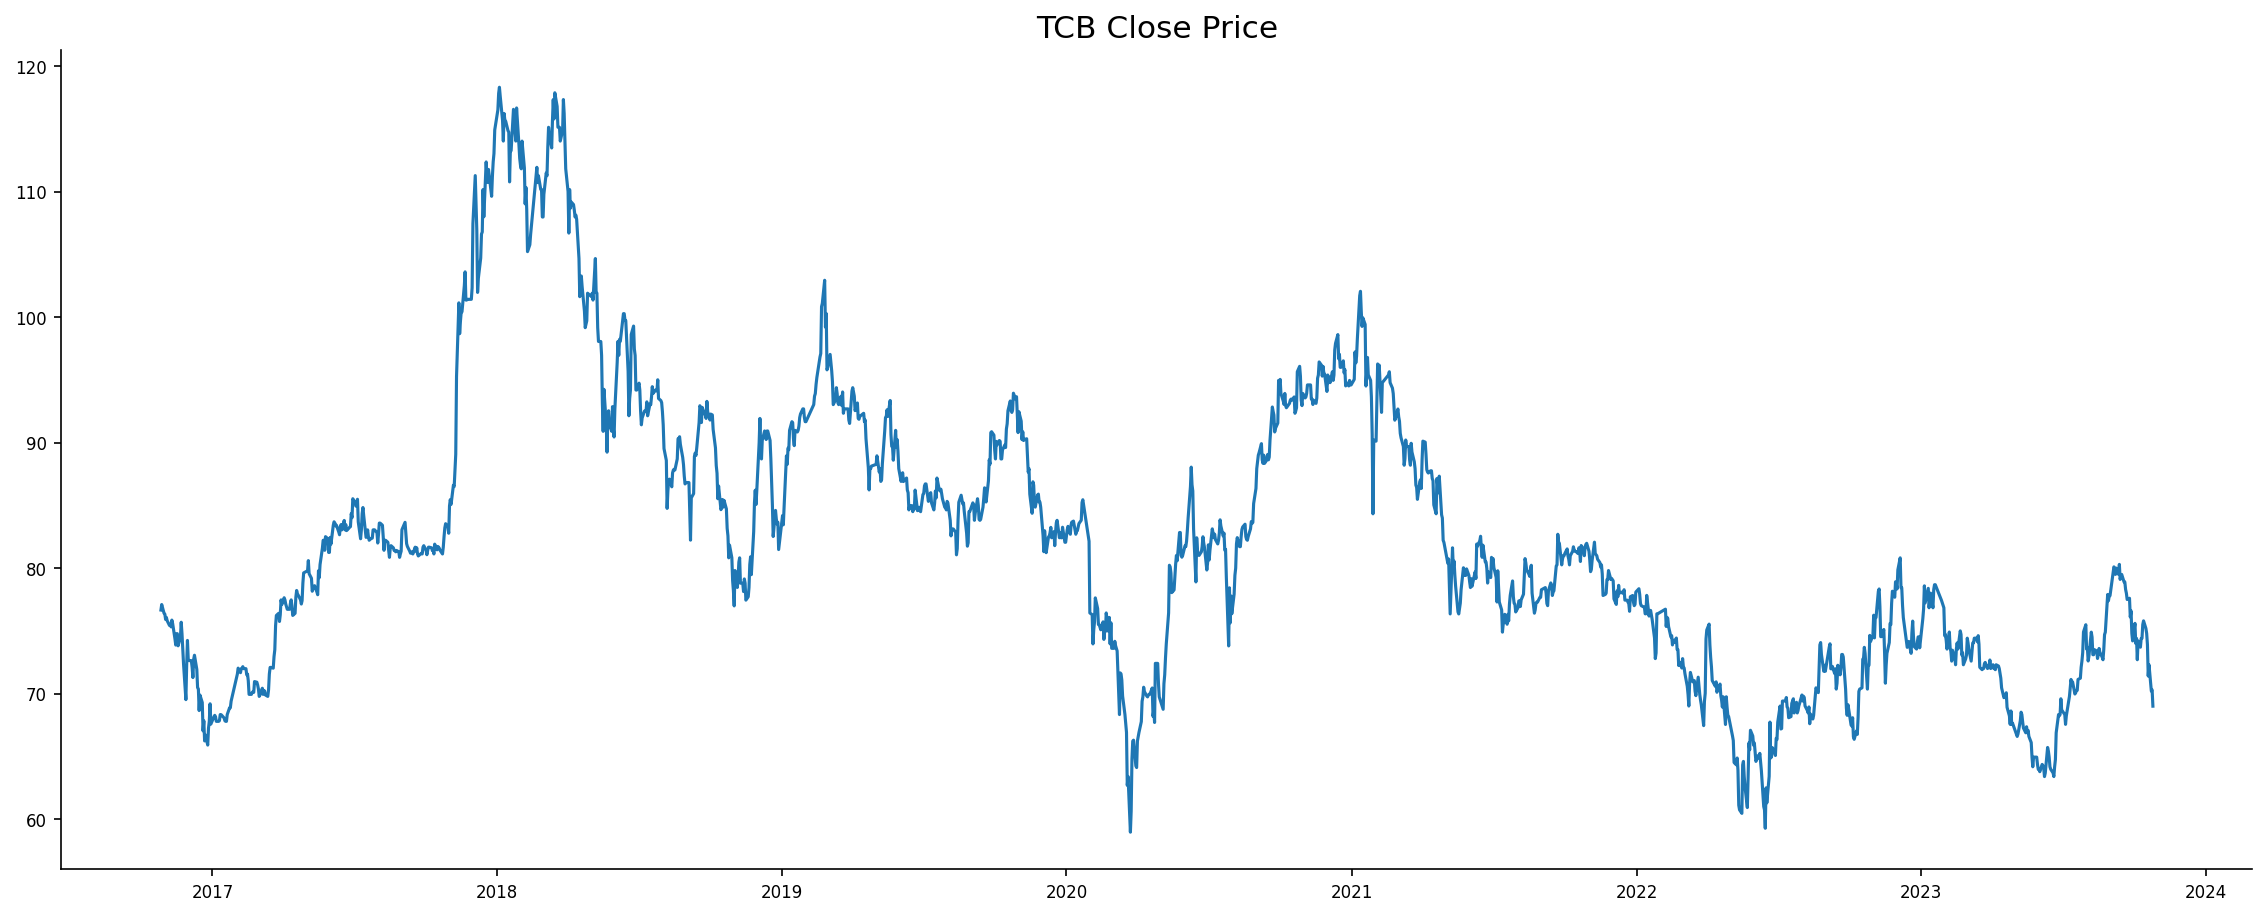

In [12]:
fig = plt.figure(figsize=(15,6))
plt.plot(df.index, df.loc[:, 'close'])
plt.title(f'TCB Close Price')
plt.show()

### **Plotting Log Returns**

<ipython-input-13-6a84d99b1263>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


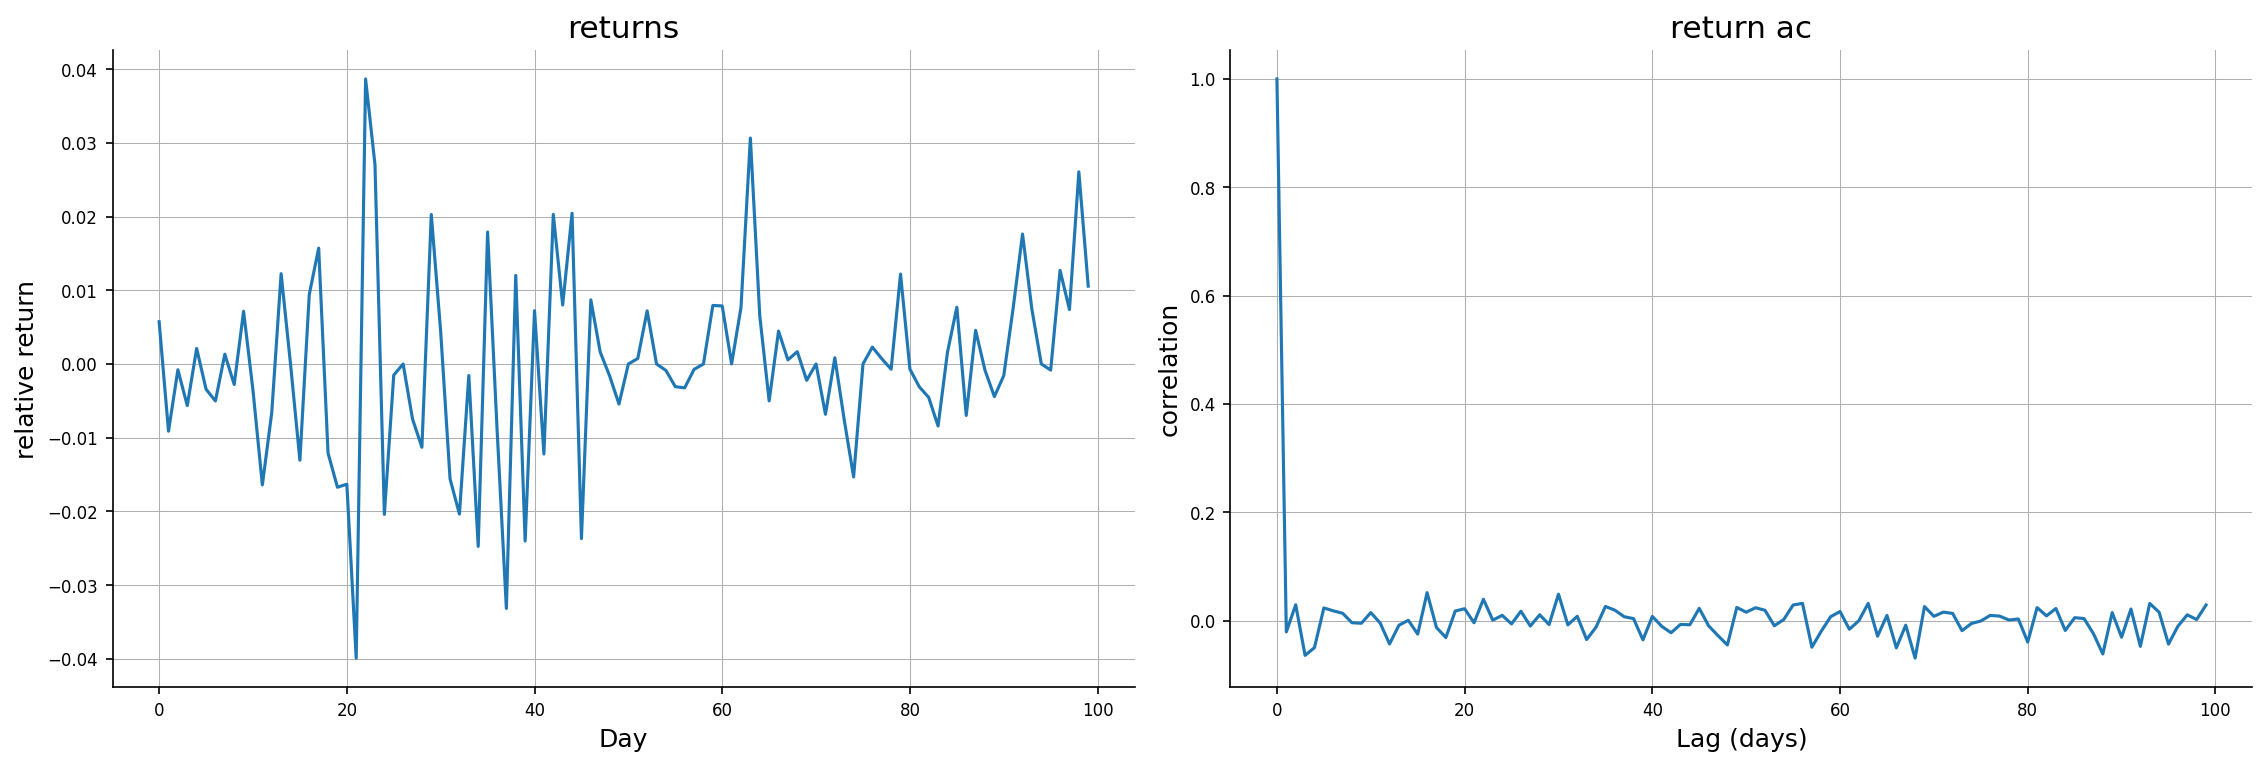

In [13]:
return_df = np.log(df['close']/df['close'].shift(1)).dropna()
# return_df = return_df[~return_df.isin([np.inf, -np.inf, np.nan]).all(axis='columns')]
return_val = return_df.values.reshape(-1, 1)
# log_returns = np.log(df['close'].values/df['close'].shift(1).values)[1:].reshape(-1, 1)
# np.allclose(log_returns, return_val)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(return_val[0:100])
axs[0].set_title('returns')
axs[1].plot(acf(return_val, 100))
axs[1].set_title('return ac')

for ax in axs:
  ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

## **Gaussianize and Prior - Normalize**




In [14]:
from sklearn.preprocessing import StandardScaler
sc1 = StandardScaler()
sc2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = sc1.fit_transform(gaussianize.fit_transform(return_val))
log_returns_preprocessed_og = sc2.fit_transform(gaussianize.fit_transform(sc1.fit_transform(return_val)))

In [15]:
# Receptive Field Size 127 from paper
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

(-4.0, 4.0)

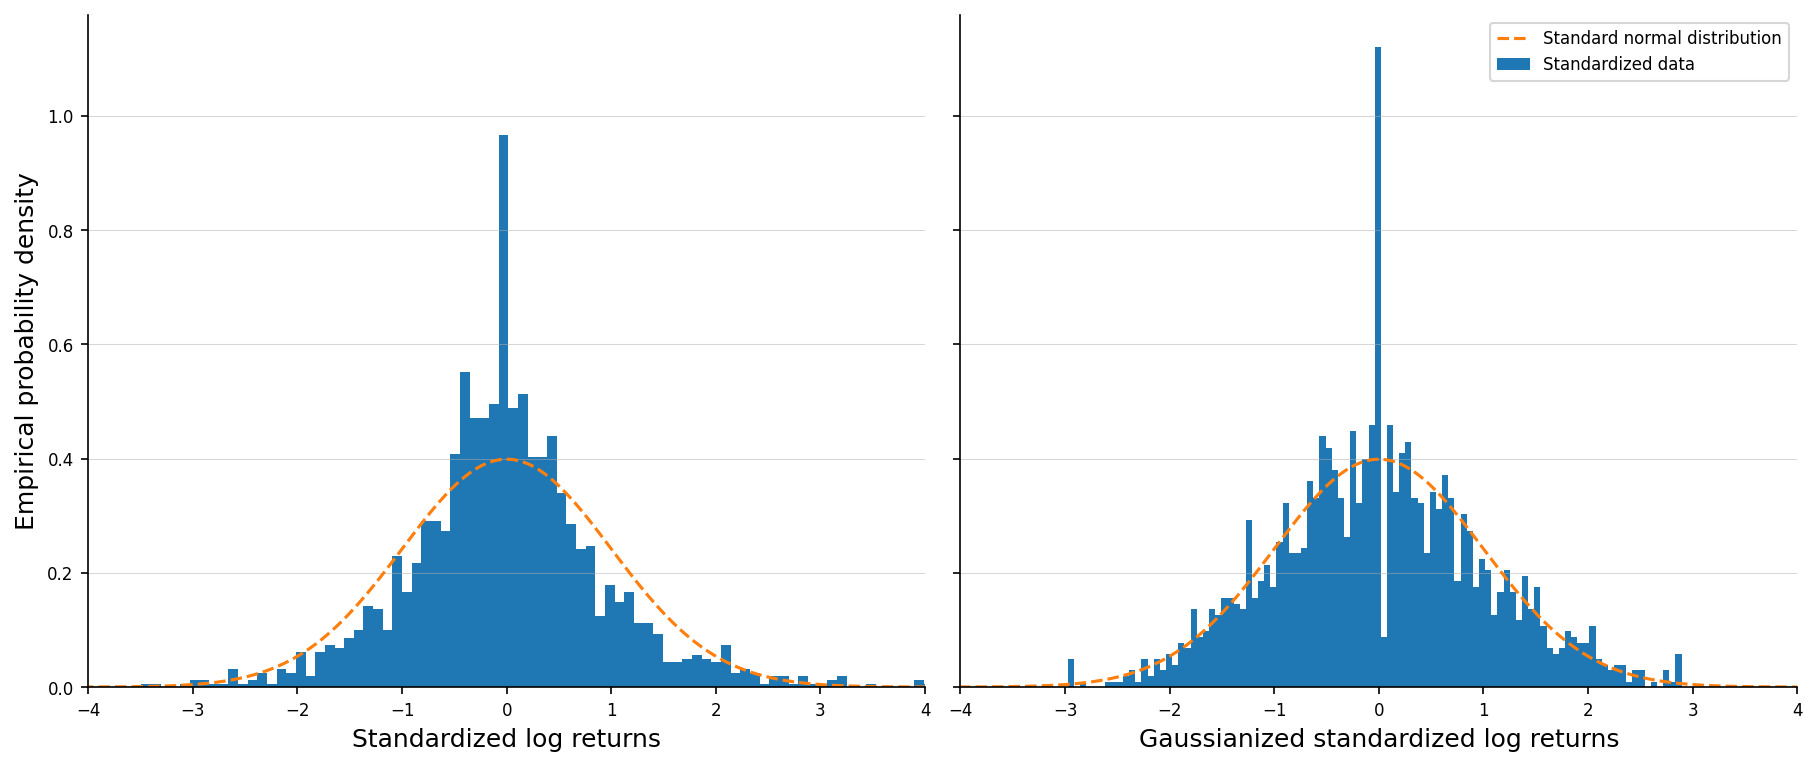

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)

# Log returns before and after the lambert W inverse transform respectively (both standardized).

ax[0].hist(sc1.transform(return_val), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed_og, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Empirical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

# **Model**

## **Temporal block, Generator, Discriminator**

In [17]:
from scipy.stats.distributions import truncweibull_min
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)


class InverseDAIN_layer(nn.Module):
    def __init__(self, dain_layer):
        super(InverseDAIN_layer, self).__init__()
        self.dain_layer = dain_layer

    def forward(self, x):
        mean = self.dain_layer.mean_layer.weight.data
        std = torch.sqrt(self.dain_layer.scaling_layer.weight.data)
        return x * std + mean

class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self, mode = 'full', mean_lr = 1e-6, gate_lr = 0.001,
                 scale_lr = 0.0001, seq_len = 127, train_mode = True, DAIN = False):
        super(Generator, self).__init__()
        self.train_mode = train_mode
        self.adaptive_normalize = DAIN
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.normalize = DAIN_Layer(mode=mode, mean_lr=mean_lr, gate_lr=gate_lr,
                                    scale_lr=scale_lr, input_dim = 3)
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)
        # self.fc = nn.Linear(1, seq_len)

    def forward(self, x):
        # Expect input to be (num_samples/batch_size, features_dim, num_features)
        if self.train_mode:
          if self.adaptive_normalize:
            x = self.normalize(x)

        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x


class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self, seq_len, mode = 'full', mean_lr = 1e-6, gate_lr = 0.001,
                 scale_lr = 0.0001,conv_dropout=0.05, DAIN = False):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.adaptive_normalize = DAIN
        self.normalize = DAIN_Layer(mode=mode, mean_lr=mean_lr, gate_lr=gate_lr, scale_lr=scale_lr, input_dim = 1)
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        if self.adaptive_normalize:
          x = self.normalize(x)
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        x = self.to_prob(x)
        return x.squeeze()

## **Dataset class**

In [18]:
class PriceDataset(Dataset):

    def __init__(self, data, seq_len):
        assert len(data) >= seq_len, \
        f"Can not split data into sliding window of length {seq_len} with data of length {len(data)}"
        self.data = data
        self.seq_len = seq_len

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.seq_len]).reshape(-1, self.seq_len).to(torch.float32)

    def __len__(self):
        return max(len(self.data)-self.seq_len, 0)

def train_val_split(data_indices, val_ratio=0.2):
  train_ratio = 1 - val_ratio
  last_train_index = int(np.round(len(data_indices) * train_ratio))
  return data_indices[:last_train_index], data_indices[last_train_index:]

In [19]:
# Get training + validation samples
train_indices, val_indices = train_val_split(np.arange(len(log_returns_preprocessed_og)))
train_data = np.array(log_returns_preprocessed_og[:val_indices[0]])
val_data = np.array(log_returns_preprocessed_og[val_indices[0]:val_indices[-1]])

train_dataset = PriceDataset(train_data, 127)
val_dataset = PriceDataset(val_data, 127)
train_dataloader = DataLoader(train_dataset, batch_size=80)
val_dataloader = DataLoader(val_dataset, batch_size=80)

In [20]:
for i, data in enumerate(val_dataloader):
  print(data)
  print(data.size())
  break

tensor([[[-0.2580,  0.5154, -0.9216,  ..., -0.1875, -0.4223,  1.4476]],

        [[ 0.5154, -0.9216, -0.8268,  ..., -0.4223,  1.4476,  0.9980]],

        [[-0.9216, -0.8268, -2.4298,  ...,  1.4476,  0.9980, -1.9229]],

        ...,

        [[-2.1337, -1.5653, -0.6988,  ...,  0.1407, -0.5750,  0.2644]],

        [[-1.5653, -0.6988,  1.0275,  ..., -0.5750,  0.2644, -0.1074]],

        [[-0.6988,  1.0275, -0.4689,  ...,  0.2644, -0.1074,  0.7048]]])
torch.Size([80, 1, 127])


# **Training**

## **Ultis for Training**

In [21]:
import json
def fix_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

class Timer:
  """Record multiple running times."""
  def __init__(self):
    """Defined in :numref:`sec_minibatch_sgd`"""
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Return the average time."""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Return the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumulated time."""
    return np.array(self.times).cumsum().tolist()

def _retrieve_model_ct(model_path, model_name):
    """Get the model file that stores network parameters"""
    return os.path.join(model_path, model_name + ".pth")

def _retrieve_model_config(model_path, model_name):
    """Get the model file that stores configurations/hyperparameters"""
    return os.path.join(model_path, model_name + ".json")

def load_model(model_path, model_name, network, device):
    """Load saved models from path"""
    config_file, model_file = _retrieve_model_config(model_path, model_name), \
    _retrieve_model_ct(model_path, model_name)
    # assert os.path.isfile(config_file), f"Config file \"{config_file}\" is not found. Check the path again"
    assert os.path.isfile(model_file), f"Model file \"{model_file}\" is not found. Check the path again"
    # with open(config_file, "r") as f:
    #     config_dict = json.load(config_file)

    network.load_state_dict(torch.load(model_file, map_location=device))
    return network

def save_model(epoch, model, optimizer, path):
  checkpoint_generator = {'epoch_idx': epoch,
                                  'model_state_dict': model.state_dict(),
                                  'optimizer_state_dict': optimizer.state_dict(),}
  checkpoint_file = os.path.join(path, f'checkpoint_{epoch}.pth')
  torch.save(checkpoint_generator, checkpoint_file)

def get_cosine_lr_scheduler(init_lr, final_lr):
    def lr_scheduler(n_epoch, epoch_idx):
        lr = final_lr + 0.5 * (init_lr - final_lr) * (1 + np.cos(np.pi * epoch_idx / n_epoch))
        return lr

    return lr_scheduler


def get_multiplicative_lr_scheduler(init_lr, drop_at, multiplicative_factor):
    def lr_scheduler(n_epoch, epoch_idx):
        lr = init_lr
        for epoch in drop_at:
            if epoch_idx + 1 >= epoch:
                lr *= multiplicative_factor
        return lr

    return lr_scheduler

## **Hyperparameters for Training**

In [22]:
# Check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
fix_seed(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Setting up hyperparameters
receptive_field_size = 127  # p. 17
data_size = return_val.shape[0]
num_epochs = 4
weight_decay = 1e-4
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002
mean_lr, std_lr, scale_lr = 1e-06, 0.0001, 0.001

In [23]:
dataset = PriceDataset(log_returns_preprocessed_og, 127)
dataloader = DataLoader(dataset, batch_size=80)
discriminator = Discriminator(seq_len)
generator = Generator()

# Check pararmeters in both networks
# # For discriminator
# for name, param in discriminator.named_parameters():
#     print(name, param.size())

# # For generator
# for name, param in generator.named_parameters():
#     print(name, param.size())

if use_cuda:
  generator = generator.cuda()
  discriminator = discriminator.cuda()

optimizerD = optim.Adam(discriminator.parameters(), weight_decay = weight_decay, lr=lr)
optimizerG = optim.Adam(generator.parameters(), weight_decay = weight_decay, lr=lr)

timer = Timer()
loss = {'D': [],
        'G': []}

lr_scheduler = get_cosine_lr_scheduler(1e-3, 1e-6)
train_mode = True
use_last_epoch = True
required_checkpoint = None

acf_real = acf(log_returns_preprocessed_og, 80)
abs_acf_real = acf(log_returns_preprocessed_og**2, 80)
le_real = acf(log_returns_preprocessed_og, 80, le=True)

checkpoint_path = '/content/drive/MyDrive/Checkpoint/GANs/Generator'

Mode =  full
Mode =  full


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## **Training Process**

In [24]:
from tqdm import tqdm

def train_model(log_ret, hidden_noise_size, num_epochs,
                batch_size, seq_len, weight_decay, lr, clip,
                train_mode = True,
                use_last_epoch = True,
                use_cuda = use_cuda,
                device = device,
                required_checkpoint = None):
  model_name = 'checkpoint_1'
  dataset = PriceDataset(log_ret, seq_len)
  dataloader = DataLoader(dataset, batch_size=batch_size)
  discriminator = Discriminator(seq_len)
  generator = Generator()
  if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
  optimizerD = optim.Adam(discriminator.parameters(), weight_decay = weight_decay, lr=lr)
  optimizerG = optim.Adam(generator.parameters(), weight_decay = weight_decay, lr=lr)
  pretrained_exists = os.path.isfile(_retrieve_model_ct(checkpoint_path, model_name))

  if pretrained_exists and train_mode:
    print('Checkpoint exists, but will be overwritten')
    for epoch in tqdm(range(num_epochs)):
      # start timer
      timer.start()

      sample_loss_D = 0.
      sample_loss_G = 0.


      # Update learning rate
      lr = lr_scheduler(num_epochs, epoch)
      for param_group in optimizerD.param_groups:
          param_group['lr'] = lr
      for param_group in optimizerG.param_groups:
          param_group['lr'] = lr


      for batch_idx, data in enumerate(train_dataloader, 0):

        discriminator.zero_grad()  # Zero the gradients
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(2)
        noise = torch.randn(batch_size, hidden_noise_size, seq_len, device=device)
        fake = generator(noise).detach()
        # print(fake.shape)
        # print(real.shape)
        # print(discriminator(real).shape)
        # print(discriminator(fake).shape)
        # print(-torch.mean(discriminator(real)))

        loss_D = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))  # Compute the loss
        loss_D.backward()  # Backward pass
        optimizerD.step()  # Update the weights
        sample_loss_D += loss_D.item()
        for param in discriminator.parameters():
          param.data.clamp_(-clip, clip)
        if batch_idx % 5 == 0:
          generator.zero_grad()  # Zero the gradients
          loss_G = -torch.mean(discriminator(generator(noise)))  # Compute the loss
          loss_G.backward()  # Backward pass
          optimizerG.step()  # Update the weights
          sample_loss_G += loss_G.item()



      loss_D_at_epoch = sample_loss_D / len(dataloader)
      loss_G_at_epoch = sample_loss_G / len(dataloader)

      loss['D'].append(loss_D_at_epoch)
      loss['G'].append(loss_G_at_epoch)

      # Stop the timer at the end of the epoch
      timer.stop()
      print(
          f'Epoch: [{epoch}/{num_epochs}]'
          + f' | Discriminator loss: {loss_D_at_epoch:.3f}'
          + f' | Generator loss: {loss_G_at_epoch:.3f}'
          + f' | Time per epoch: {timer.times[-1]:.2f} seconds')

      try:
          os.makedirs(checkpoint_path, exist_ok = True)
      except OSError as error:
          print("Directory can not be created")
      # checkpoint_generator = {'epoch_idx': epoch,
      #                               'model_state_dict': generator.state_dict(),
      #                               'optimizer_state_dict': optimizerG.state_dict(),}
      # checkpoint_file = os.path.join(checkpoint_path, f'checkpoint_{epoch}.pth')
      # torch.save(checkpoint_generator, checkpoint_file)
      save_model(epoch, generator, optimizerG, checkpoint_path)
  else:
      checkpoint_files = [os.path.join(checkpoint_path, f) for f in os.listdir(checkpoint_path)
                              if f.startswith('checkpoint_')]
      if use_last_epoch:
        checkpoint = torch.load(checkpoint_files[-1])
      else:
        if required_checkpoint is None:
          raise ValueError('Can not load checkpoint model if not provide specific epoch index')
        required_checkpoint_filename = 'checkpoint_' + str(required_checkpoint)
        for filename in checkpoint_files:
          if filename == required_checkpoint_filename:
            checkpoint = torch.load(filename)

      state_dict = checkpoint['model_state_dict']
      generator.load_state_dict(state_dict)

train_model(log_returns_preprocessed_og, nz, num_epochs,
                batch_size, seq_len, weight_decay, lr, clip)

total_time_all_epoch = timer.sum()
print("")
print(f"Total training time: {total_time_all_epoch/60:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Mode =  full
Mode =  full
Checkpoint exists, but will be overwritten


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: [0/4] | Discriminator loss: 0.000 | Generator loss: -0.095 | Time per epoch: 87.69 seconds


 25%|██▌       | 1/4 [01:28<04:25, 88.35s/it]

Epoch: [1/4] | Discriminator loss: -0.000 | Generator loss: -0.095 | Time per epoch: 80.25 seconds


 50%|█████     | 2/4 [02:49<02:47, 83.92s/it]

Epoch: [2/4] | Discriminator loss: -0.000 | Generator loss: -0.094 | Time per epoch: 80.05 seconds


 75%|███████▌  | 3/4 [04:09<01:22, 82.40s/it]

Epoch: [3/4] | Discriminator loss: 0.000 | Generator loss: -0.094 | Time per epoch: 80.10 seconds


100%|██████████| 4/4 [05:30<00:00, 82.62s/it]


Total training time: 5.47 minutes


## **Save checkpoint file (Generator only)**

In [25]:
# import pickle
# import os
# checkpoint_path = '/content/drive/MyDrive/Checkpoint/GANs/Generator'
# try:
#     os.makedirs(checkpoint_path, exist_ok = True)
# except OSError as error:
#     print("Directory can not be created")
# checkpoint_generator = {'epoch_idx': epoch,
#                               'model_state_dict': generator.state_dict(),
#                               'optimizer_state_dict': optimizerG.state_dict(),}
# checkpoint_file = os.path.join(checkpoint_path, 'checkpoint_{:09d}.pickle'.format(epoch))
# fid = open(checkpoint_file, 'wb')
# pickle.dump(checkpoint_generator, fid)
# fid.close()

# # Load model
# checkpoint_files = [os.path.join(checkpoint_path, f) for f in os.listdir(checkpoint_path)
#                             if f.startswith('checkpoint_')]

# for filename in checkpoint_files:
#     fid = open(filename, 'rb')
#     checkpoint = pickle.load(fid)
#     fid.close()

# state_dict = checkpoint['model_state_dict']
# generator.load_state_dict(state_dict)

## **Plotting Loss**

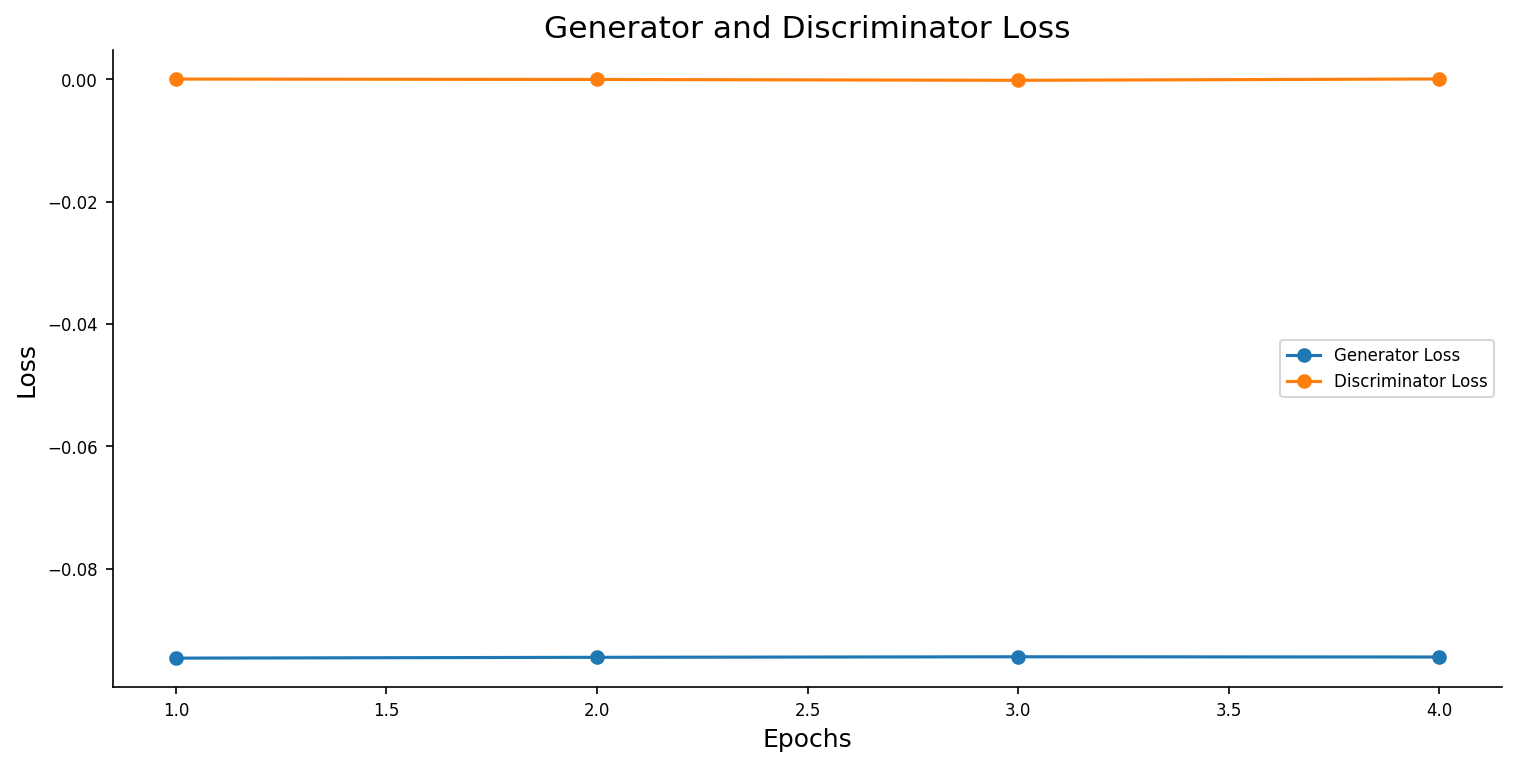

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
ax1.plot(range(1, num_epochs + 1), loss['G'], label='Generator Loss', marker='o')
ax1.plot(range(1, num_epochs + 1), loss['D'], label='Discriminator Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Generator and Discriminator Loss')
ax1.legend()

# **Evaluation**

In [27]:
generator.eval()
scores = {}
for batch_idx, data in enumerate(val_dataloader, 0):
  scores[batch_idx] = []
  real = data.to(device)
  batch_size, seq_len = real.size(0), real.size(2)
  real = real.cpu().detach().squeeze(1).permute(1, 0)

  acf_real = acf(real, batch_size).mean(axis = 1, keepdims = True)
  abs_acf_real = acf(real**2, batch_size).mean(axis = 1, keepdims = True)
  le_real = acf(real, batch_size, le=True).mean(axis = 1, keepdims = True)

  noise = torch.randn(batch_size, nz, seq_len, device=device)
  y = generator(noise).cpu().detach()
  acf_fake = acf(y.squeeze(1).permute(1, 0), batch_size).mean(axis = 1, keepdims = True)
  abs_acf_fake = acf((y.squeeze(1).permute(1, 0))**2, batch_size).mean(axis = 1, keepdims = True)
  le_fake = acf(y.squeeze(1).permute(1, 0), batch_size, le = True).mean(axis = 1, keepdims = True)

  scores[batch_idx].append(np.linalg.norm(acf_real - acf_fake))
  scores[batch_idx].append(np.linalg.norm(abs_acf_real - abs_acf_fake))
  scores[batch_idx].append(np.linalg.norm(le_real - le_fake))

  print(
        f'Batch id: [{batch_idx+1}/{len(val_dataloader)}]'
        + f' | ACF score: {scores[batch_idx][0]:.3f}'
        + f' | Abs ACF score: {scores[batch_idx][1]:.3f}'
        + f' | Leverage effect score: {scores[batch_idx][2]:.3f}')

Batch id: [1/3] | ACF score: 0.782 | Abs ACF score: 0.831 | Leverage effect score: 1.183
Batch id: [2/3] | ACF score: 0.692 | Abs ACF score: 0.668 | Leverage effect score: 1.136
Batch id: [3/3] | ACF score: 0.676 | Abs ACF score: 0.602 | Leverage effect score: 0.925


## **Plotting Distribution**

In [28]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = sc2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = sc1.inverse_transform(y)

# # some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * return_val.max()) & (y.min(axis=1) >= 2 * return_val.min())]
y -= y.mean()

Text(0, 0.5, 'Cumalative log return')

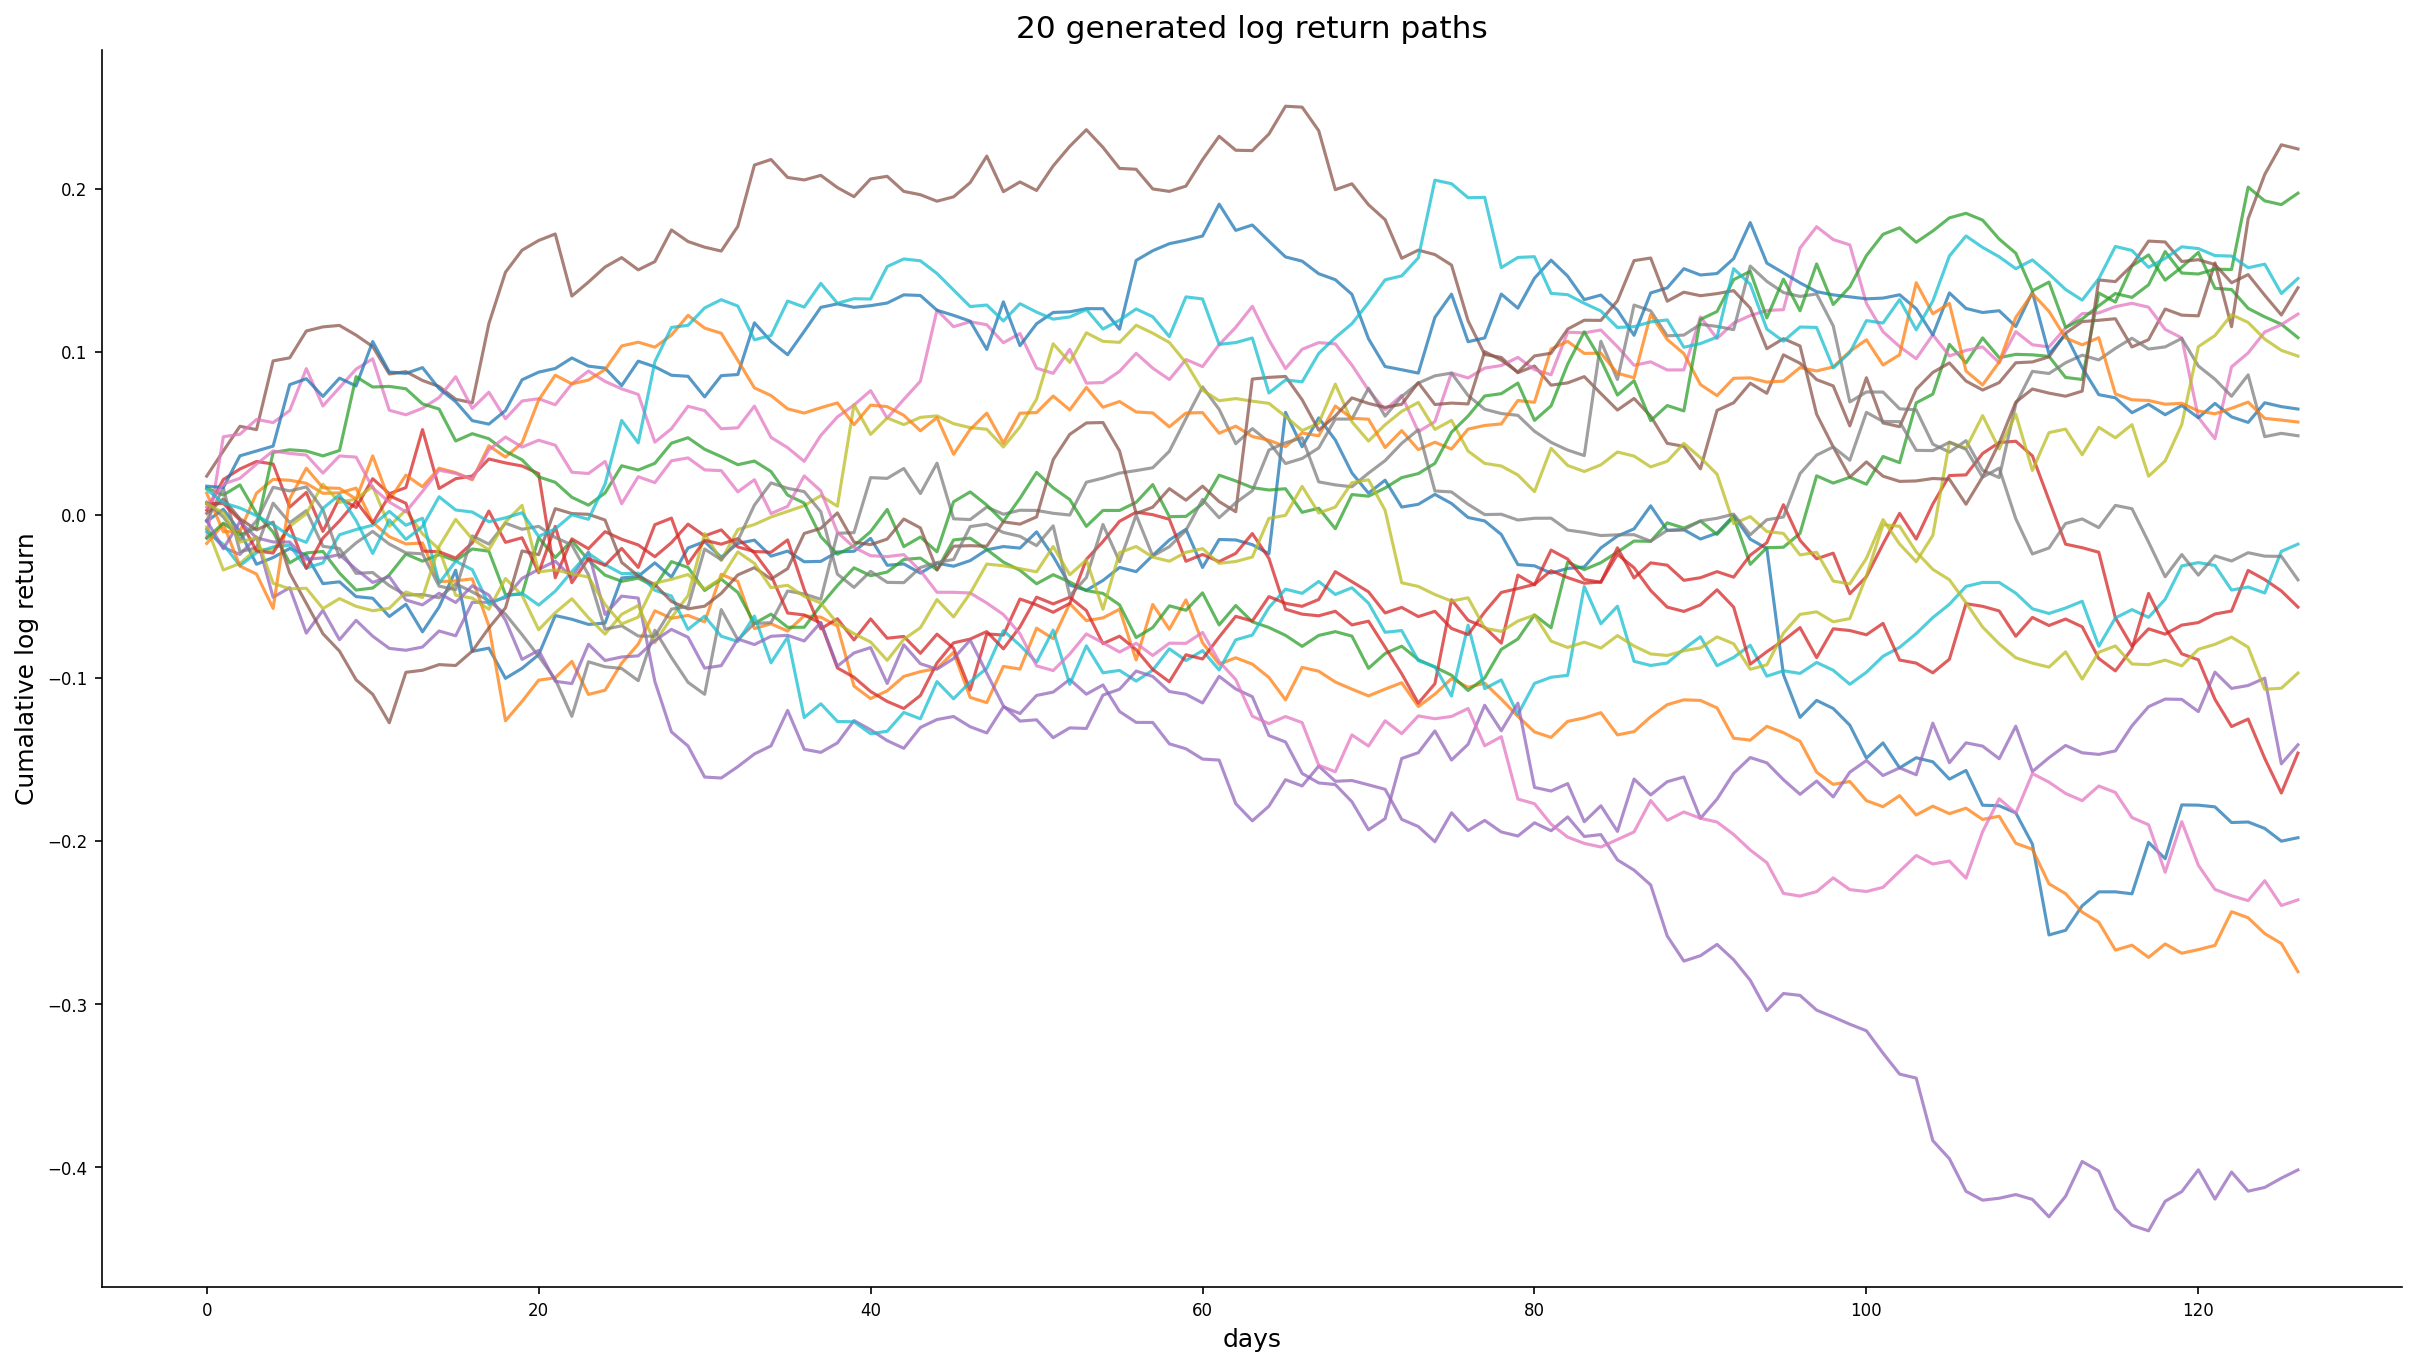

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:20], axis=1).T, alpha=0.75)
ax.set_title('20 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')

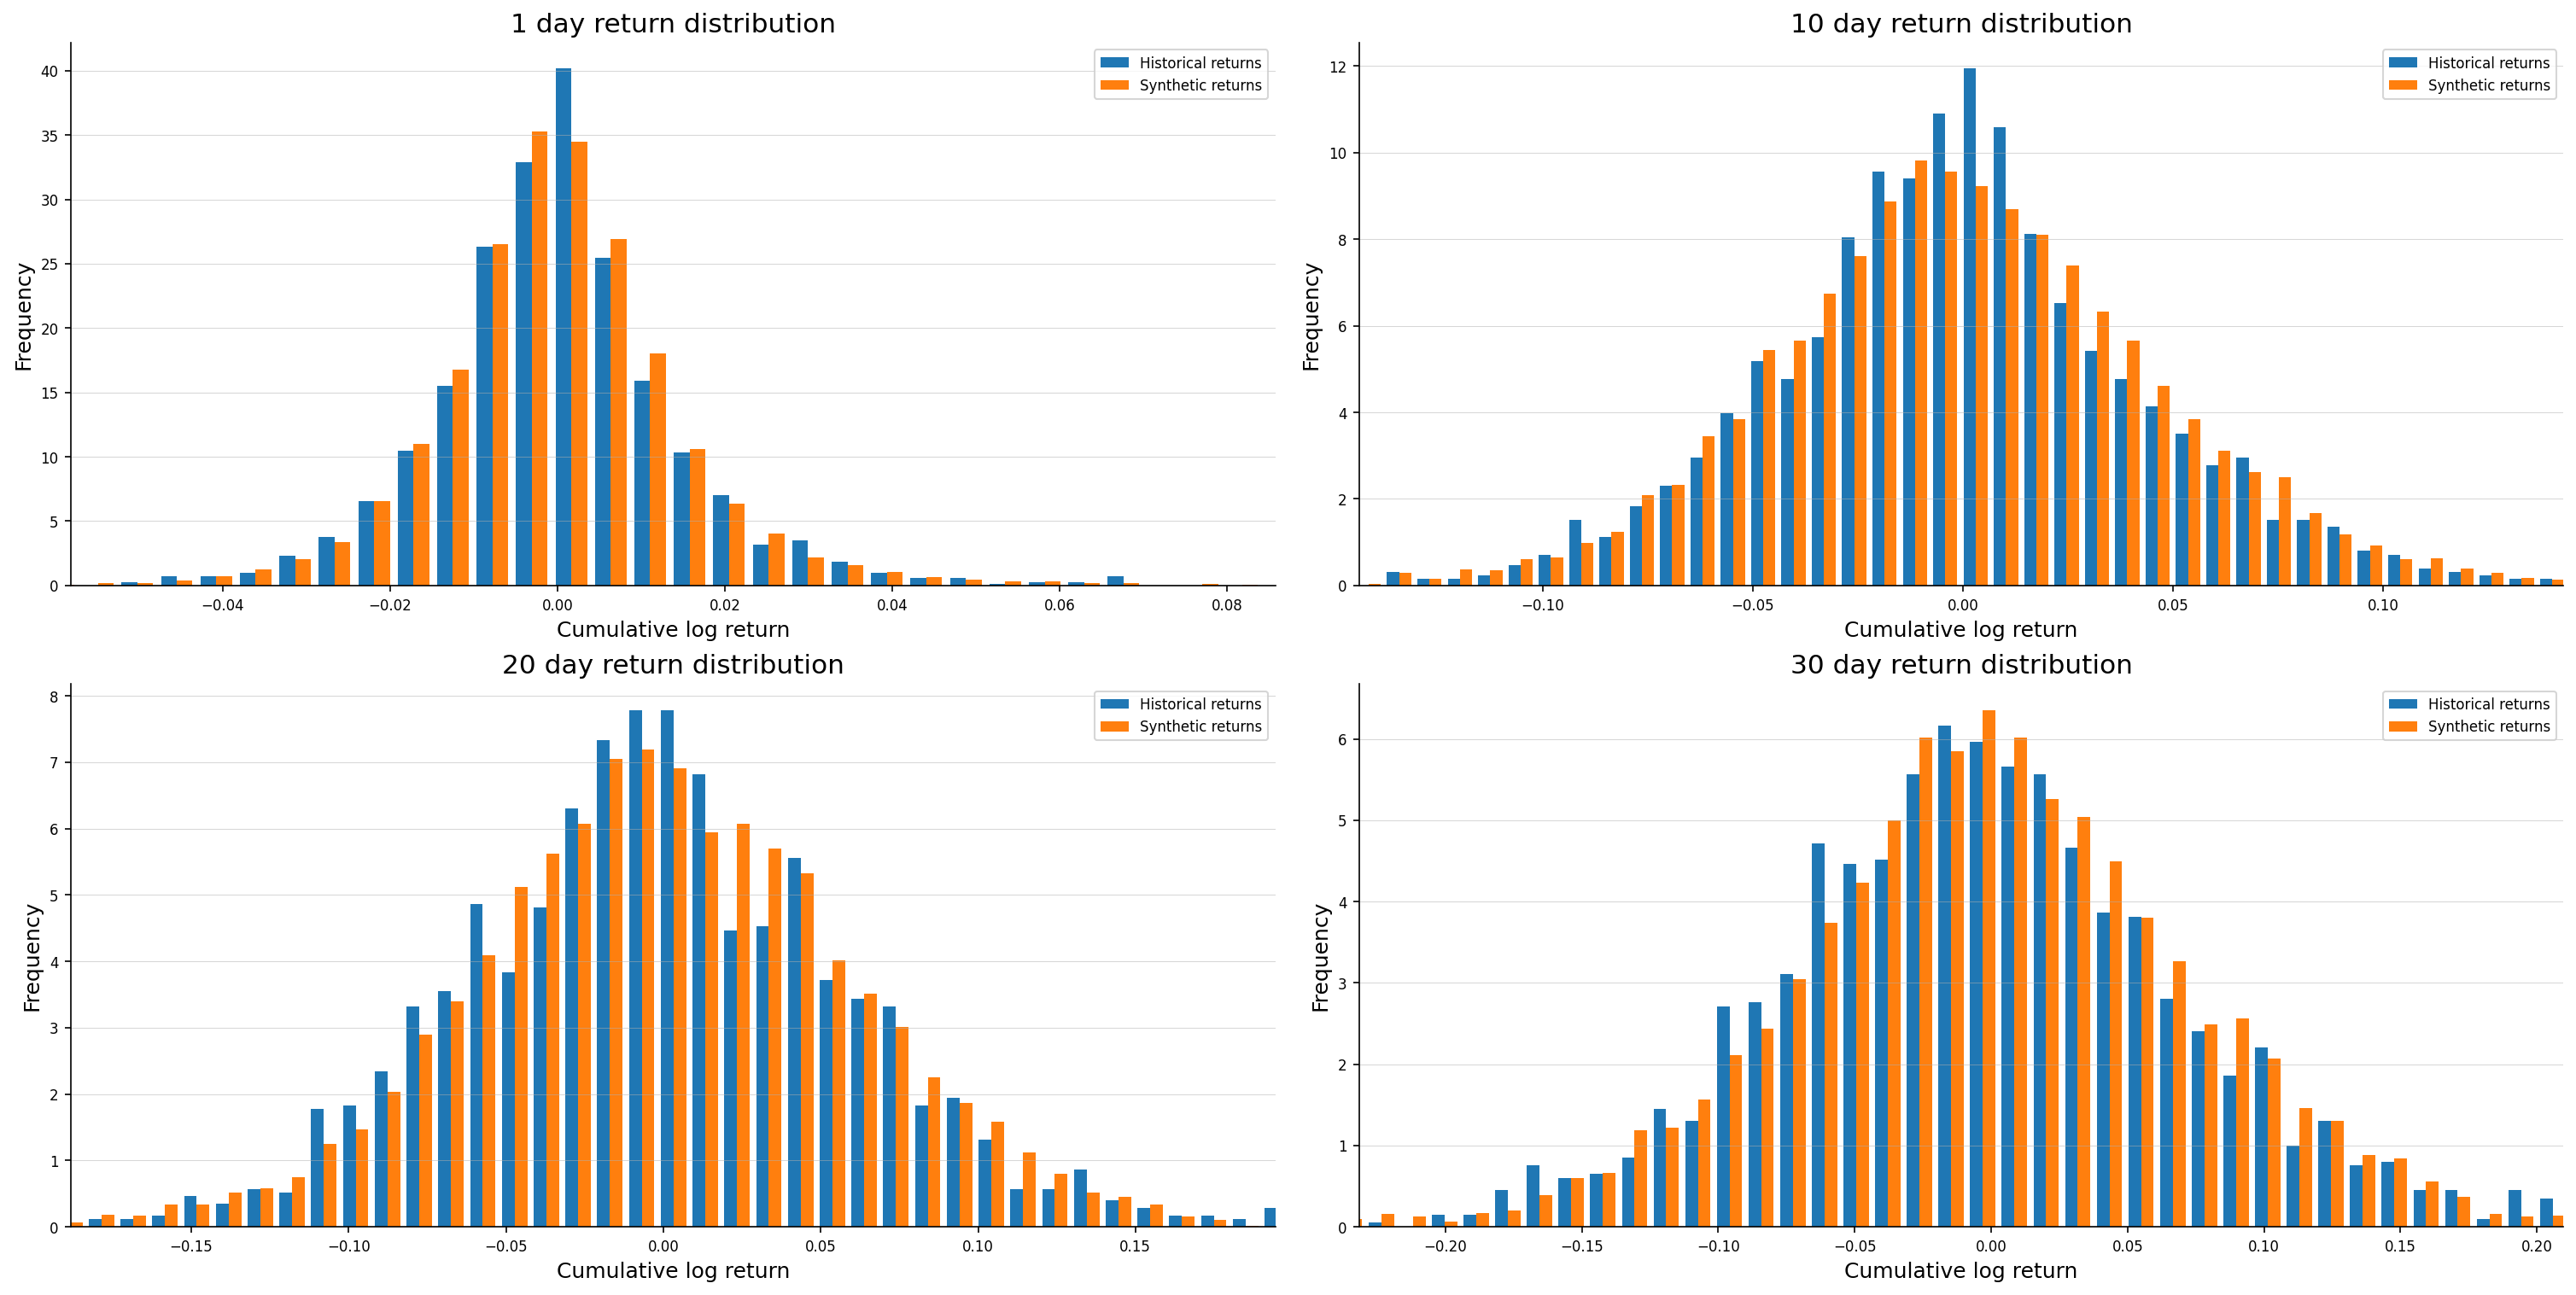

In [30]:
n_bins = 50
windows = [1, 10, 20, 30]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    real_dist = rolling_window(return_val, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax.hist([real_dist, fake_dist], bins=50, density=True)
    ax.set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    ax.set_title(f'{windows[i]} day return distribution')
    ax.yaxis.grid(True, alpha=0.5)
    ax.set_xlabel('Cumulative log return')
    ax.set_ylabel('Frequency')
    ax.legend(['Historical returns', 'Synthetic returns'])